In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows',1000)

In [3]:
# Read data from File
loan= pd.read_csv(r"C:\Users\gexce\OneDrive\Case study\loan.csv")

In [4]:
# check data 
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


## Data Pre-processing

In [5]:
#Drop the columns having only null values.
loan.dropna(axis = 1, how = 'all', inplace = True)
loan.drop(['revol_bal','total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries','collection_recovery_fee', 'last_pymnt_d','last_pymnt_amnt','next_pymnt_d', 'last_credit_pull_d','delinq_2yrs','out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv','title','application_type','policy_code','collections_12_mths_ex_med','initial_list_status','pymnt_plan','delinq_amnt','chargeoff_within_12_mths','acc_now_delinq',"member_id","emp_title","zip_code","tax_liens",'url','desc','mths_since_last_delinq','mths_since_last_record'],axis=1, inplace=True)
loan.shape

(39717, 25)

In [6]:
# Removing duplicate rows in the loanframe
loan_data = loan.drop_duplicates()
# Shape of the dataframe after removing duplicate rows
print(loan.shape)

# No duplicate rows found in the dataframe

(39717, 25)


##### Removing rows with loan status as Current(i.e loan is currently ongoing), as analysis is required on only defaulted or completed loans

In [7]:
loan = loan[loan.loan_status != "Current"]
loan.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [8]:
100 * loan.isnull().mean()

id                      0.000000
loan_amnt               0.000000
funded_amnt             0.000000
funded_amnt_inv         0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_length              2.677761
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
addr_state              0.000000
dti                     0.000000
earliest_cr_line        0.000000
inq_last_6mths          0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_util              0.129611
total_acc               0.000000
pub_rec_bankruptcies    1.806776
dtype: float64

In [9]:
#Identifying the mode value and replacing the null values with mode for categorical variables(i.e emp_length,pub_rec_bankruptcies) and droping the rows with na values in revol_util column
print('Mode : ' + loan.emp_length.mode())
# loan.emp_length.value_counts()

loan.emp_length.fillna(loan.emp_length.mode()[0],inplace=True)
loan.dropna(axis = 0, subset = ['revol_util'] , inplace = True)
loan.pub_rec_bankruptcies.fillna(loan.pub_rec_bankruptcies.mode()[0],inplace=True)

0    Mode : 10+ years
Name: emp_length, dtype: object


###### Creating new columns and correcting datatypes of columns

In [10]:
#Removing % from int_rate or revol_util column and converting them from string to integer
loan['int_rate'] = pd.to_numeric(loan['int_rate'].str.strip('%'))
loan['revol_util']= pd.to_numeric(loan['revol_util'].str.strip('%'))

#Converting issue_d into date format
loan['issue_d'] = pd.to_datetime(loan['issue_d'] , format='%b-%d')
loan['issue_d'] = loan['issue_d'].apply(lambda x: x.replace(year=2024))

# Deriving new column as issue_month and issue_year from issue_d column
loan['issue_month'] = loan['issue_d'].dt.strftime('%b')
loan['issue_week']= loan['issue_d'].dt.weekday.astype(object)

# Removing months from term column values
loan['term']=loan['term'].apply(lambda x: int(x.replace(' months',''))).astype(int)

# Removing special chartacters and words from values of emp_length column 
loan['emp_length']=loan['emp_length'].apply(lambda x: x.replace('years','').replace('+','').replace('< 1','0.5').replace('year','')).astype(float)


###### Outliers identification in the data

In [11]:
numerical_col= ['loan_amnt','funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment','annual_inc','dti','revol_util']
categorical_col= ['term','grade', 'sub_grade','emp_length', 'home_ownership','verification_status','loan_status','purpose', 'addr_state','inq_last_6mths','open_acc','pub_rec','total_acc','pub_rec_bankruptcies','issue_month','issue_week']
extra_col=['id','issue_d','earliest_cr_line']

len(numerical_col+categorical_col+extra_col)

27

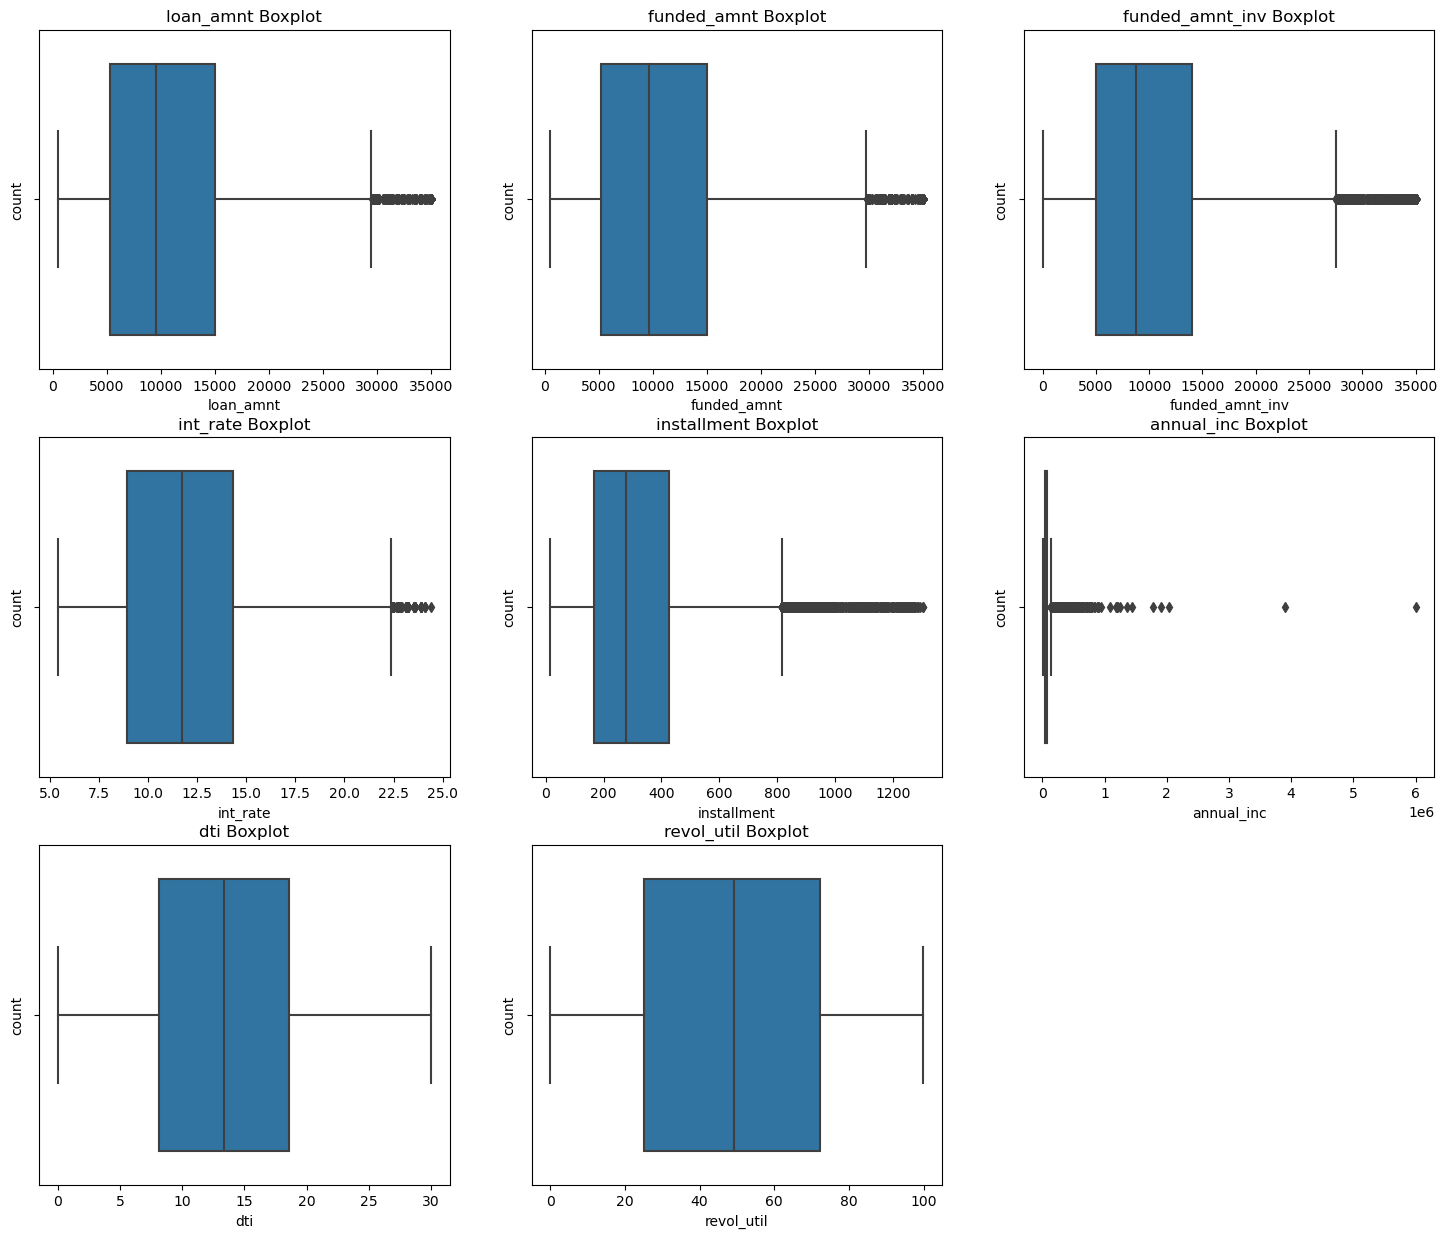

In [12]:
# Finding outliers for each numerical column
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through numerical columns and create a boxplot for each
for i, col in enumerate(numerical_col):
    sns.boxplot(x=loan[col], ax=axes[i])
    axes[i].set_ylabel('count')
    axes[i].set_title(f'{col} Boxplot')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [13]:
#finding quartiles for each numerical column
for i in numerical_col:
    print(i + ' at different quartiles')
    print(loan[i].quantile([0.01,0.1,0.5,0.10,0.50,0.75,0.90,0.95,0.96,0.97,0.98,0.99,1.0]))

loan_amnt at different quartiles
0.01     1200.0
0.10     3125.0
0.50     9600.0
0.10     3125.0
0.50     9600.0
0.75    15000.0
0.90    21600.0
0.95    25000.0
0.96    25000.0
0.97    28000.0
0.98    30000.0
0.99    35000.0
1.00    35000.0
Name: loan_amnt, dtype: float64
funded_amnt at different quartiles
0.01     1200.0
0.10     3075.0
0.50     9600.0
0.10     3075.0
0.50     9600.0
0.75    15000.0
0.90    20000.0
0.95    25000.0
0.96    25000.0
0.97    27000.0
0.98    30000.0
0.99    35000.0
1.00    35000.0
Name: funded_amnt, dtype: float64
funded_amnt_inv at different quartiles
0.01      672.928581
0.10     2850.000000
0.50     8750.000000
0.10     2850.000000
0.50     8750.000000
0.75    14000.000000
0.90    19975.000000
0.95    24506.582238
0.96    24950.000000
0.97    25828.061320
0.98    29890.414864
0.99    34721.583150
1.00    35000.000000
Name: funded_amnt_inv, dtype: float64
int_rate at different quartiles
0.01     5.42
0.10     7.14
0.50    11.71
0.10     7.14
0.50    11.7

In [14]:
#Removing values with annual income greater than equal to 0.99 quartile as there is an exponential increase in annual income around the 99th percentile. Therefore, it is advisable to exclude values beyond the 99th percentile.
annual_inc_99_per = loan['annual_inc'].quantile(0.99)
loan = loan[loan.annual_inc <= annual_inc_99_per]

In [15]:
# check size of data

loan.shape

(38142, 27)

In [16]:
# now we will do analysis 
# first analysis will be based on Univariate analysis
# check loan status first
print(100*  (loan['loan_status'].value_counts()/loan['loan_status'].value_counts().sum()))

loan_status
Fully Paid     85.401919
Charged Off    14.598081
Name: count, dtype: float64


As per above analysis below are the observations
Observation : 
- 85.40 percent of people have fully paid the loan whereas approx. 
- 14.60 percent of people defaulted.

will check loan status fully paid vs charged off


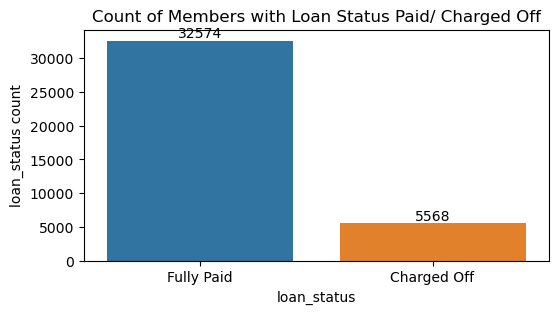

In [17]:
plt.figure(figsize=(6,3))
ax = sns.countplot(x='loan_status', data=loan)
for p in ax.patches:
    height = int(p.get_height()) if p.get_height().is_integer() else p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Count of Members with Loan Status Paid/ Charged Off')
plt.ylabel('loan_status count')
plt.show()

let us check term loan

term
36    75.436527
60    24.563473
Name: count, dtype: float64


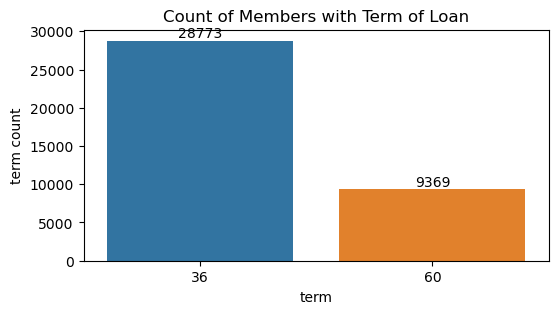

In [18]:
print(100*  (loan['term'].value_counts()/loan['term'].value_counts().sum()))
plt.figure(figsize=(6,3))
ax = sns.countplot(x='term', data=loan)
for p in ax.patches:
    height = int(p.get_height()) if p.get_height().is_integer() else p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Count of Members with Term of Loan')
plt.ylabel('term count')
plt.show()

As per above analysis below are the observations

Observation: 
    More then 75% loans are taken fore duration of 36 months in comparison to 60 months term plan

Let's analysis on grade

grade
B    30.360233
A    26.157517
C    20.289969
D    13.140370
E     6.814011
F     2.485449
G     0.752451
Name: count, dtype: float64


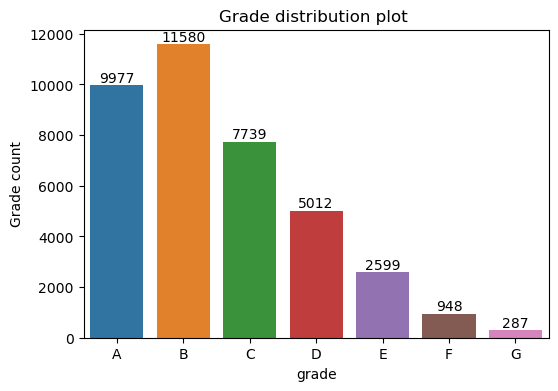

In [19]:
print(100*  (loan['grade'].value_counts()/loan['grade'].value_counts().sum()))
plt.figure(figsize=(6,4))
sorted_order = sorted(loan['grade'].unique())
ax = sns.countplot(x = 'grade', data = loan, order=sorted_order)
for p in ax.patches:
    height = int(p.get_height()) if p.get_height().is_integer() else p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Grade distribution plot ')
plt.ylabel('Grade count')
plt.show()

Obervations - Findings : More then 50% borrowers belong to group A and B in comparizon to another groups

lets do analysis on sub grade


sub_grade
A4    7.482565
B3    7.320015
A5    7.060458
B5    6.816633
B4    6.355199
C1    5.322217
B2    5.185884
C2    5.004981
A3    4.716585
B1    4.682502
A2    3.930051
C3    3.846154
D2    3.319176
C4    3.140895
C5    2.975722
A1    2.967857
D3    2.883960
D1    2.406796
D4    2.370091
D5    2.160348
E1    1.866709
E2    1.575691
E3    1.316134
E4    1.098527
E5    0.956950
F1    0.781291
F2    0.600388
F3    0.440459
F4    0.380158
F5    0.283152
G1    0.238582
G2    0.191390
G4    0.133711
G3    0.115358
G5    0.073410
Name: count, dtype: float64


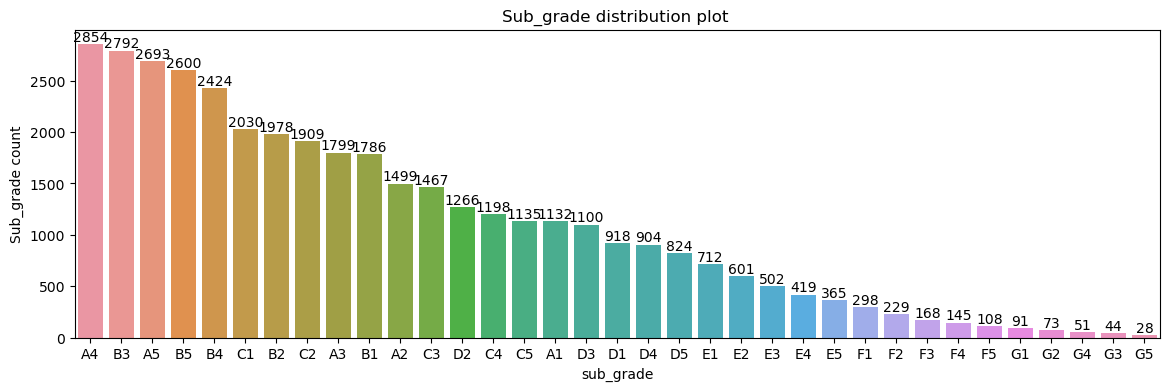

In [20]:
print(100*  (loan['sub_grade'].value_counts()/loan['sub_grade'].value_counts().sum()))
plt.figure(figsize=(14,4))
sorted_order = sorted(loan['sub_grade'].unique())
ax = sns.countplot(x = 'sub_grade', data = loan, order=loan['sub_grade'].value_counts().index)
for p in ax.patches:
    height = int(p.get_height()) if p.get_height().is_integer() else p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Sub_grade distribution plot ')
plt.ylabel('Sub_grade count')
plt.show()

Observation: The majority of loans within grades A and B are predominantly acquired through subgrades 4 and 5, with each grade encompassing five subgrades.

Lets do anlysis on employee


In [ ]:
print(100*  (loan['emp_length'].value_counts()/loan['emp_length'].value_counts().sum()))
plt.figure(figsize=(10,3))
sns.countplot(x = 'emp_length', data = loan, order=sorted(loan.emp_length))
plt.title('Employee years of experience')
plt.ylabel('emp_length count')
plt.show()

emp_length
10.0    24.587069
0.5     11.711499
2.0     11.116355
3.0     10.416339
4.0      8.675476
5.0      8.295317
1.0      8.224529
6.0      5.631587
7.0      4.441298
8.0      3.715065
9.0      3.185465
Name: count, dtype: float64


Observartion: Around 1/4th of loans are taken by people with more then 10 years of experience

lets do analysis on loan amount

In [ ]:
bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000]
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-30k', '30k-35k']
loan['loan_amnt_bins'] = pd.cut(loan['loan_amnt'], bins=bins, labels=labels)
# Count the number of loans in each bin
loan_amnt_bin_counts = loan['loan_amnt_bins'].value_counts().sort_index()
bin_counts_df = loan_amnt_bin_counts.reset_index()
bin_counts_df.columns = ['Loan Amount Bin', 'Number of Loans']

fig = px.bar(bin_counts_df, x='Loan Amount Bin', y='Number of Loans',
             title='Number of Loans per Loan Amount Bin',
             labels={'Loan Amount Bin': 'Loan Amount Bin', 'Number of Loans': 'Number of Loans'})
fig.show()
print(100 * (loan['loan_amnt_bins'].value_counts()/loan['loan_amnt_bins'].value_counts().sum()))

Higher amuunt of loan has taken in the amount bracket of 5k-10k

In [ ]:
import matplotlib.dates as mdates
loan_1 = loan.copy()

loan_1['issue_d'] = pd.to_datetime(loan_1['issue_d'])
loan_1.set_index('issue_d', inplace=True) 

monthly_loan_amnt = loan_1['loan_amnt'].resample('M').sum()  
sorted_monthly_loan_amnt = monthly_loan_amnt.sort_index()

# Plotting the trend of loan amounts
plt.figure(figsize=(8, 3))
plt.plot(sorted_monthly_loan_amnt, marker='o')
plt.xticks(sorted_monthly_loan_amnt.index, [date.strftime('%b%y') for date in sorted_monthly_loan_amnt.index])
plt.title('Trend of Loan Amount')
plt.xlabel('Date')
plt.ylabel('Loan Amount')
plt.grid(True)
plt.show()

Observation: 
 - Majority of the loans taken in the month of December
 - Around 1/3rd of loans are taken between 5k to 10k 

now let's check interest rates

In [ ]:
# Distribution of interest rate
plt.figure(figsize=(5,3))
sns.distplot(sorted(loan.int_rate),kde=True,bins=25)
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.title('Distribution of Interest Rate')
plt.show()

Observations:
Majority of loans are taken between 10-15%, with decreasing flow after 15%.

#### Ownership

In [ ]:
print(100*  (loan['home_ownership'].value_counts()/loan['home_ownership'].value_counts().sum()))
plt.figure(figsize=(10,3))
sns.countplot(x = 'home_ownership', data = loan, order=sorted(loan.home_ownership))
plt.title('home_ownership')
plt.ylabel('home_ownership count')
plt.show()

Observation: 
 - Just 7% of loan recipients are homeowners.
 - Over 90% of loan recipients reside in mortgaged or rented accommodations.

Lets check verificaiton status 

In [ ]:
print(100*  (loan['verification_status'].value_counts()/loan['verification_status'].value_counts().sum()))
plt.figure(figsize=(10,3))
sns.countplot(x = 'verification_status', data = loan, order=sorted(loan.verification_status))
plt.title('verification_status')
plt.ylabel('verification_status count')
plt.show()

Observation: 
Over 50% of individuals have undergone either verification or source verification, with 43% people not verified

#### lets check loan purpose

In [ ]:
print(100*  (loan['purpose'].value_counts()/loan['purpose'].value_counts().sum()))
plt.figure(figsize=(22,5))
sns.countplot(x = 'purpose', data = loan, order=sorted(loan.purpose))
plt.title('purpose')
plt.ylabel('purpose count')
plt.show()

Observation: More then 45% of loans are taken for debt consolidation 

##### Distibution of DTI

In [ ]:
# Distribution of dti
plt.figure(figsize=(7,3))
sns.distplot(loan.dti,kde=True,bins=20)
plt.xlabel('DTI ratio')
plt.ylabel('Density')
plt.title('Distribution of DTI ratio',fontsize=12)
plt.show()

Observation:  Majority of the borrowers have very large debt compared to the income registered, concentrated in the 10-15 DTI ratio.

##### Public record bankruptch

In [ ]:
print(100* loan['pub_rec_bankruptcies'].value_counts(normalize=True))
# Distribution of pub_rec_bankruptcies
plt.figure(figsize=(6,3))
sns.countplot(x=loan.pub_rec_bankruptcies)
plt.xlabel('Public Record Bankruptcies')
plt.ylabel('Density')
plt.title('Distribution of Public Record Bankruptcies',fontsize=12)
plt.show()

Observation: Around 95% of loans have no public record bankruptcies

## Now lets do Bivariate and Multivariate Analysis

In [ ]:
# Comparison of interest rate based on grade
plt.figure(figsize=(7,3))
sns.barplot(data=loan,x='int_rate',y='grade')
plt.xlabel('Interest Rate')
plt.ylabel('Grade')
plt.title('Comparison of Interest Rate Based On Grade',fontsize=12)
plt.show()

Observation: The creditworthiness of a borrower, as reflected by their grade, is a key factor in determining the interest rate. Borrowers with lower grades (higher risk) are typically charged higher interest rates

In [ ]:
# Distribution of Term based on Grade
plt.figure(figsize=(6,4))
sns.countplot(data=loan,x='term',hue='grade')
plt.xlabel('Term')
plt.ylabel('Count')
plt.title('Distribution of Term For Grade',fontsize=12)
plt.show()

Observation: Majority of loans are taken by grade A and B are for 36 months

In [ ]:
# Distribution of house_ownership based on loan_status
plt.figure(figsize=(7,3))
sns.countplot(data=loan,x='home_ownership',hue='loan_status')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.title('Distribution of Home Ownership For Loan Status',fontsize=12)
plt.legend(loc='upper center')
plt.show()

Observation: People who own their property are less likely to default on their loans compared to those who rent or have a mortgage on their property.

In [ ]:
# Distribution of addr_state
plt.figure(figsize=(15,3))
sns.countplot(x=loan.addr_state,hue=loan.loan_status)
plt.xlabel('Count')
plt.ylabel('State')
plt.title('Distribution of State',fontsize=12)
plt.show()

Observation: There is high frequency of people who have defaulted and fully paid off loans in CA,FL,NY

In [ ]:
# Distribution of DTI based on Grade
plt.figure(figsize=(7,3))
sns.histplot(data=loan,x='dti',hue='loan_status',bins=10)
plt.xlabel('DTI')
plt.ylabel('Count')
plt.title('Distribution of DTI For Loan Status',fontsize=12)
plt.show()

There's a connection between debt-to-income (DTI) ratio and loan approval. While loans with a DTI ratio in the 10-15 range might have more defaults, the overall trend shows that a higher DTI ratio leads to a greater risk of default.

In [ ]:
# Distribution of annual_inc based on loan_status
plt.figure(figsize=(7,3))
sns.histplot(data=loan,x='annual_inc',hue='loan_status',bins=20,kde=True)
plt.xlabel('Annual Income')
plt.ylabel('Count')
plt.title('Distribution of Annual Income For Loan Status',fontsize=12)
plt.show()

Observation: The lower a borrower's annual income, the higher the chance of loan default. Conversely, borrowers with higher incomes are less likely to default.

In [ ]:
plt.figure(figsize=(7,3))

sns.barplot(x='term', y='loan_amnt', hue='loan_status', data=loan, estimator=np.median)
plt.title('Term vs loan amount')


Observation: The loan term (36 or 60 months) doesn't appear to influence whether a borrower defaults on the loan. In other words, there's an equal distribution of defaults and non-defaults across both loan terms.

In [ ]:
grade_ord = loan.grade.unique()
grade_ord.sort()
plt.figure(figsize=(8,3))
sns.barplot(x='grade', y='loan_amnt', hue='loan_status', data=loan, estimator=np.median, order = grade_ord)
plt.suptitle('Term vs loan amount')
plt.show()

Observation: Comparatively Annual income is higher for lower grades.

In [ ]:
df = loan.groupby(['purpose', 'loan_status'], as_index=False)['loan_amnt'].median()

plt.figure(figsize=(8,4))
sns.barplot(x='purpose', y='loan_amnt', hue='loan_status', data= loan,order=df[df.loan_status == 'Charged Off'].sort_values(by='loan_amnt').purpose)
plt.title('Purpose vs loan amount')
plt.xticks(rotation=90)
plt.show()

 Small businesses face a higher risk of defaulting on loans with larger amounts.

In [ ]:
df = loan.groupby(['purpose', 'loan_status'], as_index=False)['int_rate'].median()

plt.figure(figsize=(8,4))
sns.barplot(x='purpose', y='int_rate', hue='loan_status', data= loan, estimator=np.median, order = df[df.loan_status == 'Charged Off'].sort_values(by='int_rate').purpose)
plt.title('Purpose vs interest rate')
plt.xticks(rotation=90)
plt.show()

High-interest home loans often result in defaults, a trend similarly observed in small business and debt consolidation loans.

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(211)
sns.scatterplot(x='loan_amnt', y='annual_inc', data=loan[loan.loan_status == 'Charged Off'])
plt.yscale('log')
plt.title('Loan Amount vs Loan interest rate (Charged Off)')
plt.subplot(212)
sns.scatterplot(x='loan_amnt', y='annual_inc', data=loan[loan.loan_status == 'Fully Paid'])
plt.yscale('log')
plt.title('Loan Amount vs Loan interest rate (Fully Paid)')
plt.show()

Fully paid and Charged Off loans show comparable patterns in relation to annual income, with a linear model having a significantly low slope.

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(loan[numerical_col].corr(),annot=True,cmap="YlGnBu_r")
plt.show()